## Load env

In [1]:
# Load packages
import scanpy as sc
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import anndata as ad
import liana as li
import decoupler as dc
import omnipath as op 

In [2]:
# Setup the global plotting parameters
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100, color_map = "viridis", frameon=True, transparent=True,
                    dpi_save=800, facecolor="None", format="pdf", figsize=[4,4])

sns.set_style("whitegrid", {'axes.grid' : False})

# Figure output directory
sc.settings.figdir = 'lr_analysis/'

# Set seed for reproducibility
np.random.seed(0)

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.4 pynndescent==0.5.11


In [3]:
# Color maps
colour_dict_sample = {'DMSO_PDO': '#8383FF', 
               'SN38_PDO': '#531B93',  
               'DMSO_PDO_CAF': '#E39097', 
               'SN38_PDO_CAF':'#941751', 
               'DMSO_CAF': '#C0C0C0', 
               'SN38_CAF': '#5E5E5E'}

In [4]:
# Import data
input_file_path_rna = '../02_preprocessing_multimodal/ex0015_pdo_rna_adata.h5ad'  # h5ad file exported from preprocessing pipeline
input_file_path_adt = '../02_preprocessing_multimodal/ex0015_pdo_adt_adata.h5ad'  # h5ad file exported from preprocessing pipeline

signal_adata_rna = sc.read_h5ad(input_file_path_rna)
signal_adata_adt = sc.read_h5ad(input_file_path_adt)

# Inspect data shape
print(signal_adata_rna, ": data shape:", signal_adata_rna.shape)
print(signal_adata_adt, ": data shape:", signal_adata_adt.shape)

AnnData object with n_obs × n_vars = 30895 × 33740
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers', 'leidenr0.1', 'cell_type', 'cell_type_condition', 'S_score', 'G2M_score', 'phase'
    var: 'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leidenr0.1_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'scrublet', 'sub_lib_id_colors'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances' : data shape: (30895, 33740)
AnnData object with n_obs × n_vars = 30895 × 21
    obs: 'n_genes_by_counts', 'log1p_n_g

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
signal_adata_rna.obs_names = signal_adata_rna.obs['barcode_seq'].astype('str') + '_' + signal_adata_rna.obs['sublib_index'].astype('str')
signal_adata_adt.obs['barcode_seq'] = signal_adata_adt.obs_names

# Make names unique
signal_adata_rna.var_names =  signal_adata_rna.var_names.astype(str)
signal_adata_rna.var_names_make_unique()

raw_adata = signal_adata_rna.raw.to_adata()

# Make names unique
raw_adata.var_names =  raw_adata.var_names.astype(str)
raw_adata.var_names_make_unique()

signal_adata_rna.raw = raw_adata



/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Generate the LR matrix for Liana

In [6]:
# Check avail methods
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


In [7]:
lr_network_df = pd.read_csv('data/omni_intercell_network.csv')

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_26990/3030615380.py:1: DtypeWarning: Columns (18,33) have mixed types. Specify dtype option on import or set low_memory=False.


In [8]:
# Filter for sereted molecules
lr_network_df_secreted = lr_network_df[lr_network_df['secreted_intercell_source'] == True]

In [9]:
# Filter based on ligand, cell_surface_ligand, secreted_enzyme, secreted_receptor
ligand_functional_classes = ['ligand']  # Replace with your list of strings
lr_network_df_secreted_ligands = lr_network_df_secreted[lr_network_df_secreted['parent_intercell_source'].isin(ligand_functional_classes)]

In [10]:
lr_network_df_secreted = lr_network_df[lr_network_df['secreted_intercell_source'] == True]

## Generate the ULM inferred Regulons

In [11]:
# All pdo cells
pdo_adata = signal_adata_rna[signal_adata_rna.obs['cell_type'].isin(['PDO'])]

In [12]:
pdo_adata.obs['cell_type_condition'].value_counts()

cell_type_condition
PDO_DMSO_PDO_CAF    8835
PDO_SN38_PDO_CAF    6667
PDO_SN38_PDO        5045
PDO_DMSO_PDO        3650
Name: count, dtype: int64

In [13]:
# Load the TF regulon network
net = dc.get_collectri(organism='human', split_complexes=False)

In [14]:
# Run ULM Enrichment Analysis
dc.run_ulm(
    mat=pdo_adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

193 features of mat are empty, they will be removed.
Running ulm on mat with 24197 samples and 33547 targets for 728 sources.


100%|██████████| 3/3 [00:17<00:00,  5.95s/it]
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/decoupler/method_ulm.py:130: ImplicitModificationWarning: Setting element `.obsm['ulm_estimate']` of view, initializing view as actual.


In [15]:
acts = dc.get_acts(pdo_adata, obsm_key='ulm_estimate')
acts

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.


AnnData object with n_obs × n_vars = 24197 × 728
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers', 'leidenr0.1', 'cell_type', 'cell_type_condition', 'S_score', 'G2M_score', 'phase'
    uns: 'cell_type_colors', 'leiden', 'leidenr0.1_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'scrublet', 'sub_lib_id_colors'
    obsm: 'X_pca', 'X_phate', 'ulm_estimate', 'ulm_pvals'

In [16]:
df = dc.rank_sources_groups(acts, groupby='sample_id', reference='DMSO_PDO', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,DMSO_PDO_CAF,DMSO_PDO,HIF1A,61.567558,1.827581,0.0,0.0
1,DMSO_PDO_CAF,DMSO_PDO,SP1,58.681389,1.722647,0.0,0.0
2,DMSO_PDO_CAF,DMSO_PDO,SALL1,54.758469,1.137119,0.0,0.0
3,DMSO_PDO_CAF,DMSO_PDO,FOXD3,53.955542,1.085217,0.0,0.0
4,DMSO_PDO_CAF,DMSO_PDO,HDAC5,52.328893,1.196491,0.0,0.0
...,...,...,...,...,...,...,...
2179,SN38_PDO_CAF,DMSO_PDO,HDAC4,-46.297003,-1.050803,0.0,0.0
2180,SN38_PDO_CAF,DMSO_PDO,HIF3A,-46.912840,-1.207566,0.0,0.0
2181,SN38_PDO_CAF,DMSO_PDO,SOX9,-54.336931,-1.040405,0.0,0.0
2182,SN38_PDO_CAF,DMSO_PDO,SKIL,-68.096048,-1.394338,0.0,0.0


In [17]:
df_mono = dc.rank_sources_groups(acts, groupby='sample_id', reference='DMSO_PDO_CAF', method='t-test_overestim_var')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


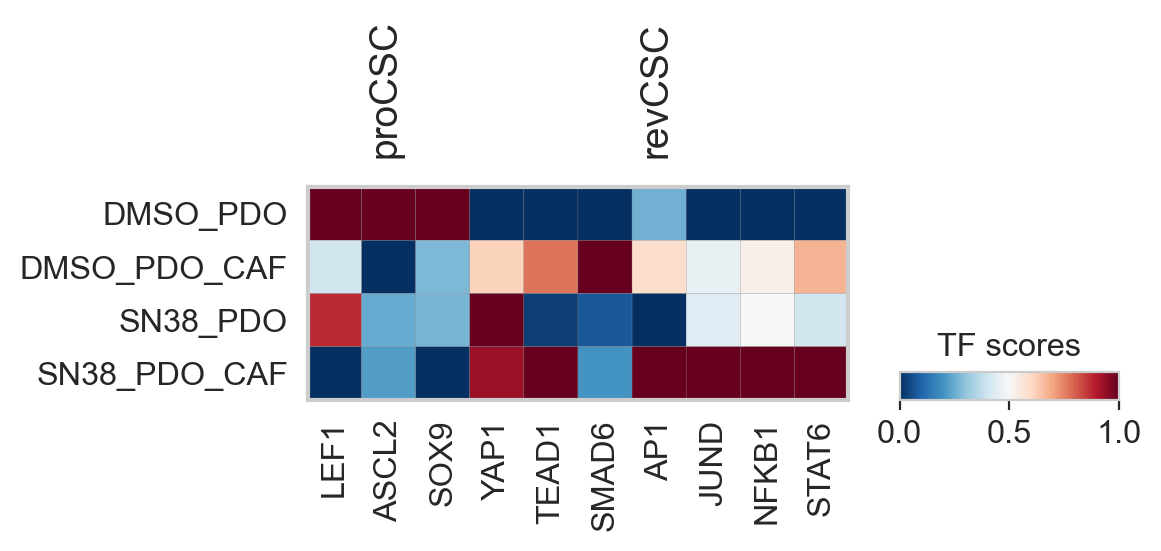

In [18]:
markers = {
    'proCSC': ['LEF1', 'ASCL2', 'SOX9'],
    'revCSC': ['YAP1', 'TEAD1', 'SMAD6', 'AP1', 'JUND', 'NFKB1', 'STAT6']
}

sc.pl.matrixplot(acts, markers, 'sample_id', dendrogram=False, standard_scale='var',
                 colorbar_title='TF scores', cmap='RdBu_r', save='pdo_TF_regulon_activity.png')

## Run the LR Liana tool

In [19]:
# Run rank_aggregate across the individual cultures
# Not run as takes a long time
#li.mt.rank_aggregate(signal_adata_rna, groupby='cell_type_condition', expr_prop=0.1, verbose=True)

In [20]:
liana_res_all = pd.read_csv('data/pdo_liana_lr_analysis_all.csv')

In [21]:
# Filter the list for secreted ligands from the OmniPath database
sender_ligands = lr_network_df_secreted_ligands['genesymbol_intercell_source']
liana_res_all_ligands = liana_res_all[liana_res_all['ligand_complex'].isin(sender_ligands)]

In [22]:
signal_adata_rna.uns['liana_res'] = liana_res_all_ligands

## Extract relevant interactions

In [23]:
# Isolate relevant sender population
cc_interactions_out = ['Fibroblast_DMSO_PDO_CAF', 'PDO_DMSO_PDO_CAF', 'PDO_DMSO_PDO']  # Replace with your list of strings
liana_res_all_ligands_filter_out = liana_res_all_ligands[liana_res_all_ligands['source'].isin(cc_interactions_out)]

# Isolate interactions that could signal 
cc_interactions_in = ['PDO_DMSO_PDO_CAF', 'PDO_DMSO_PDO'] 
liana_res_all_ligands_filter = liana_res_all_ligands_filter_out[liana_res_all_ligands_filter_out['target'].isin(cc_interactions_in)]

In [24]:
ligand_markers = liana_res_all_ligands_filter['ligand_complex'].unique()

In [25]:
caf_cc_deg_df = pd.read_csv("data/caf_dmso_cc_degs.csv")
pdo_mono_deg_df = pd.read_csv("data/pdo_dmso_mono_degs.csv")

In [26]:
# Filter the two lists
pdo_mono_deg_df_filter = pdo_mono_deg_df[pdo_mono_deg_df['names'].isin(ligand_markers)]
caf_cc_deg_df_filter = caf_cc_deg_df[caf_cc_deg_df['names'].isin(ligand_markers)]

In [27]:
pdo_mono_deg_df_filter_sorted = pdo_mono_deg_df_filter.sort_values(by='names')
pdo_mono_deg_df_filter_sorted.columns =  ['index', 'names', 'pdo_scores', 'pdo_logfoldchanges', 'pdo_pvals', 'pdo_pvals_adj']

caf_cc_deg_df_filter_sorted = caf_cc_deg_df_filter.sort_values(by='names')
caf_cc_deg_df_filter_sorted.columns = ['index', 'names', 'cc_scores', 'cc_logfoldchanges', 'cc_pvals', 'cc_pvals_adj']

In [28]:
merged_de_ligand_df = pd.merge(pdo_mono_deg_df_filter_sorted, caf_cc_deg_df_filter_sorted, on='names')

In [29]:
# Define a assignment based on p-value and quadrant
def color_point(row):
    if row['cc_pvals_adj'] < 0.05:
        if row['pdo_logfoldchanges'] > 0 and row['cc_logfoldchanges'] > 0 and row['pdo_pvals_adj'] < 0.05:  # 1st quadrant
            return 'Q1_shared_pro_caf'
        elif row['pdo_logfoldchanges'] > 0 and row['cc_logfoldchanges'] > 0 and row['pdo_pvals_adj'] > 0.05:  # 2nd quadrant
            return 'Q5_caf_only'
        elif row['pdo_logfoldchanges'] < 0 and row['cc_logfoldchanges'] > 0 and row['pdo_pvals_adj'] < 0.05:  # 2nd quadrant
            return 'Q5_caf_only'
        elif row['pdo_logfoldchanges'] < 0 and row['cc_logfoldchanges'] > 0 and row['pdo_pvals_adj'] > 0.05:  # 2nd quadrant
            return 'Q5_caf_only'
        elif row['pdo_logfoldchanges'] < 0 and row['cc_logfoldchanges'] < 0 and row['pdo_pvals_adj'] < 0.05:  # 3rd quadrant
            return 'Q3_revCSC_only'
        elif row['pdo_logfoldchanges'] < 0 and row['cc_logfoldchanges'] < 0 and row['pdo_pvals_adj'] > 0.05:  # 3rd quadrant
            return 'Q6_shared_pro_rev'
        elif row['pdo_logfoldchanges'] > 0 and row['cc_logfoldchanges'] < 0 and row['pdo_pvals_adj'] < 0.05:  # 4th quadrant
            return 'Q4_proCSC_only'
        elif row['pdo_logfoldchanges'] > 0 and row['cc_logfoldchanges'] < 0 and row['pdo_pvals_adj'] > 0.05:  # 4th quadrant
            return 'Q6_shared_pro_rev'
    return 'Q7_non_significant'  # Points not meeting the criteria of revCSC/CAF deregulation

merged_de_ligand_df['color'] = merged_de_ligand_df.apply(color_point, axis=1)

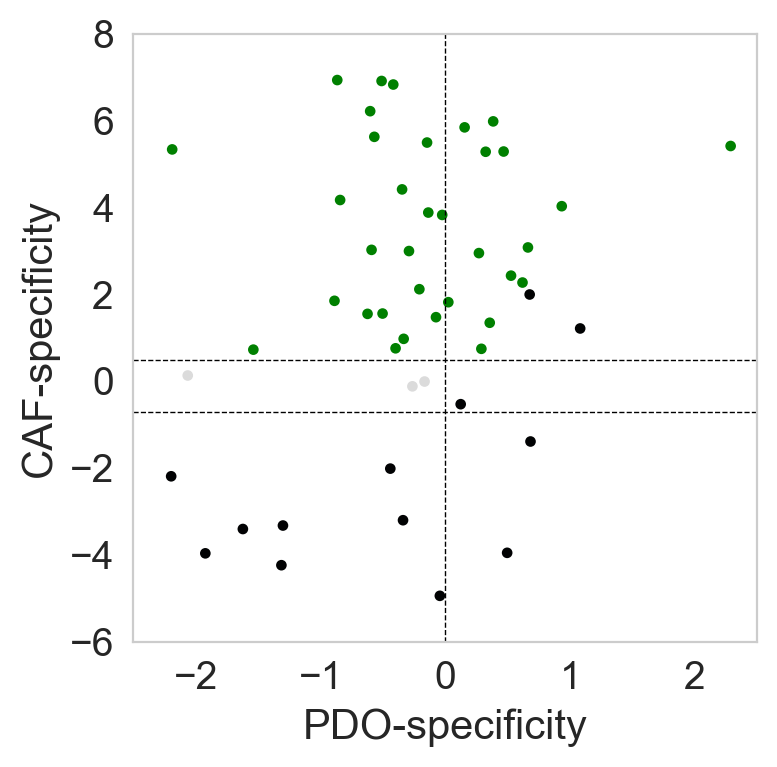

In [30]:
# Colours
colors = {'Q1_shared_pro_caf':'#010203', 'Q5_caf_only':'#008000', 'Q3_revCSC_only':'#010203',
          'Q6_shared_pro_rev':'#010203', 'Q4_proCSC_only':'#010203', 'Q7_non_significant':'#DBDBDB'}

fig, ax = plt.subplots()

# Plot each point
for color in merged_de_ligand_df['color'].unique():
    subset = merged_de_ligand_df[merged_de_ligand_df['color'] == color]
    ax.scatter(subset['pdo_logfoldchanges'], subset['cc_logfoldchanges'], s=8, c=subset['color'].map(colors))

# Hide grid lines
ax.grid(False)

# Adjust limits
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-6,8)

# dashed horizontal and vertical lines at x=0 and y=0
ax.axhline(y=0.5, color='black', linestyle='dashed', linewidth=0.5)
ax.axhline(y=-0.7, color='black', linestyle='dashed', linewidth=0.5)
ax.axvline(x=0, color='black', linestyle='dashed', linewidth=0.5)

# Axis labels
plt.xlabel('PDO-specificity', fontsize=15)
plt.ylabel('CAF-specificity', fontsize=15)

# Save figure
fig.savefig('lr_analysis/deg_ligand_specificity.pdf', dpi=300)

In [31]:
# Filter on autocrine revCSC and paracrine CAF factors
caf_paracrine_id = ['Q5_caf_only'] 
caf_paracrine_df = merged_de_ligand_df[merged_de_ligand_df['color'].isin(caf_paracrine_id)]
caf_paracrine_df.sort_values(by='cc_logfoldchanges', ascending=False, inplace=True)

caf_paracrine_factors = caf_paracrine_df['names'].to_list()

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_26990/1441596407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
# Generate heatmap of DE Ligands and receptors
hm_df = merged_de_ligand_df.set_index("names")
hm_df_lfc = hm_df[['cc_logfoldchanges']].sort_values('cc_logfoldchanges')

In [33]:
pdo_caf_ligs = hm_df_lfc.index.to_list()
ligands = list(reversed(pdo_caf_ligs))

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


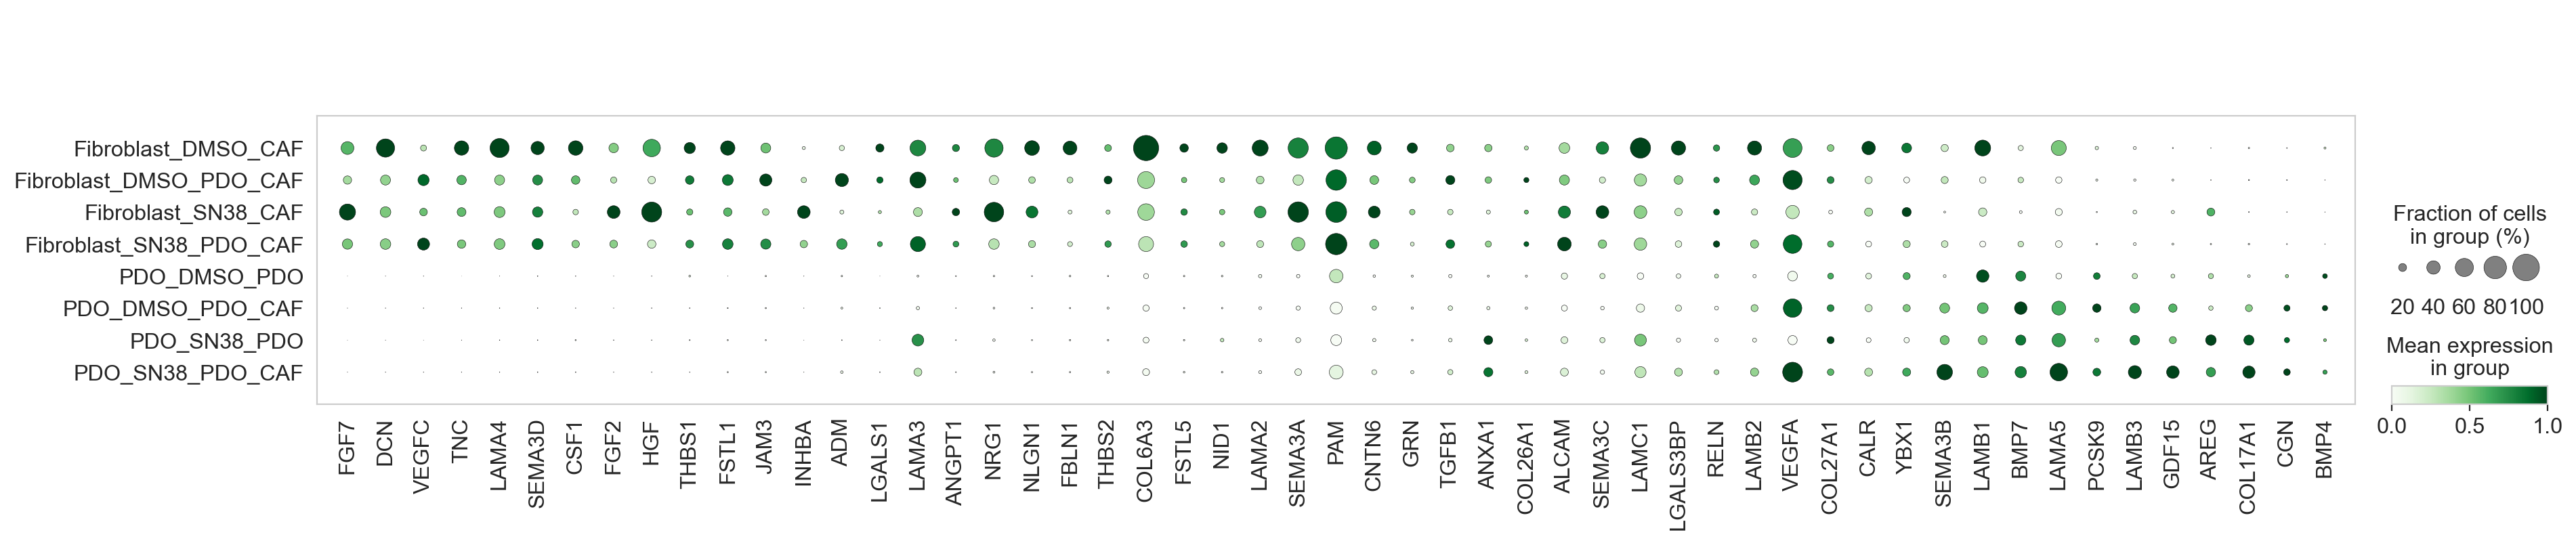

In [34]:
pdo_caf_images = hm_df_lfc.index

sc.pl.dotplot(signal_adata_rna, ligands, groupby='cell_type_condition', dendrogram=False, 
              cmap='Greens', standard_scale='var', save='_filtered_LR_interactions.pdf')

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_26990/2067954280.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


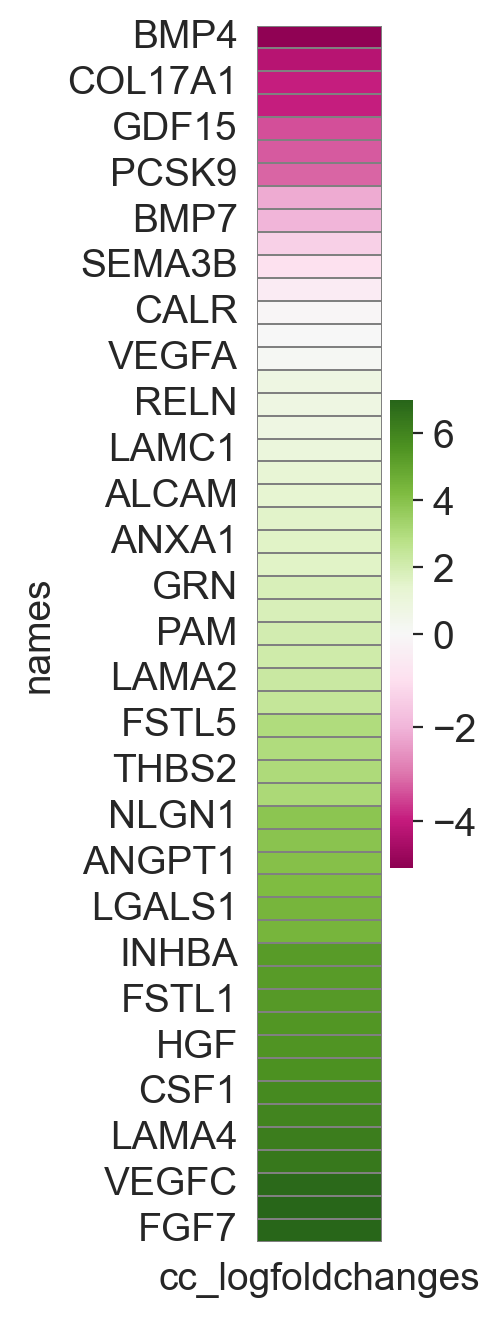

In [35]:
fig, ax = plt.subplots(figsize=(1, 8))
colormap = mpl.cm.get_cmap('PiYG')
offset = mcolors.TwoSlopeNorm(vmin=-5, vcenter=-0, vmax=7)
sns.heatmap(hm_df_lfc, cmap=colormap, norm=offset, linewidths = 0.05, linecolor='grey')
plt.savefig('LR_02_test/cc_logFC.pdf', dpi=600, transparent=True, bbox_inches='tight')